# KAGGLE COMPETITION
### House Prices: Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting

#### Por Guilherme Nicchio

### LIBRARIES

In [12]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
#Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder


import xgboost as xgb

### LOADING DATA SETS

In [48]:
df_train = pd.read_csv("train.csv", header = 0, delimiter = ",")
df_test = pd.read_csv("test.csv", header = 0, delimiter = ",")
sub_df = pd.read_csv("sample_submission.csv", header = 0, delimiter = ",")

Joining df_test with sample submissions

In [49]:
df_test = sub_df.merge(df_test)

In [50]:
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

Train set shape: (1460, 81)
Test set shape: (1459, 81)


### SUMMING AREAS TO CREATE A BETTER FEATURE

In [51]:
df_train['TotalArea'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_test['TotalArea'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']

Deleting the old columns

In [52]:
for i in ['TotalBsmtSF', '1stFlrSF', "2ndFlrSF"]:
    df_train = df_train.drop(i, axis = 1)
    df_test = df_test.drop(i, axis = 1)

In [53]:
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

Train set shape: (1460, 79)
Test set shape: (1459, 79)


### OUTLIERS IN TRAIN SET

Looking at the features in the data set it is expected that **OverallQual** (Overall quality), **Neighborhood**, **GrLivArea** (Above grade (ground) living area square feet), and **Total Area** have a strong relatinship with the Sale Price, so outliers in this variables may make our prediction model bad. So let's take a look at those variables.

**GrLivArea**

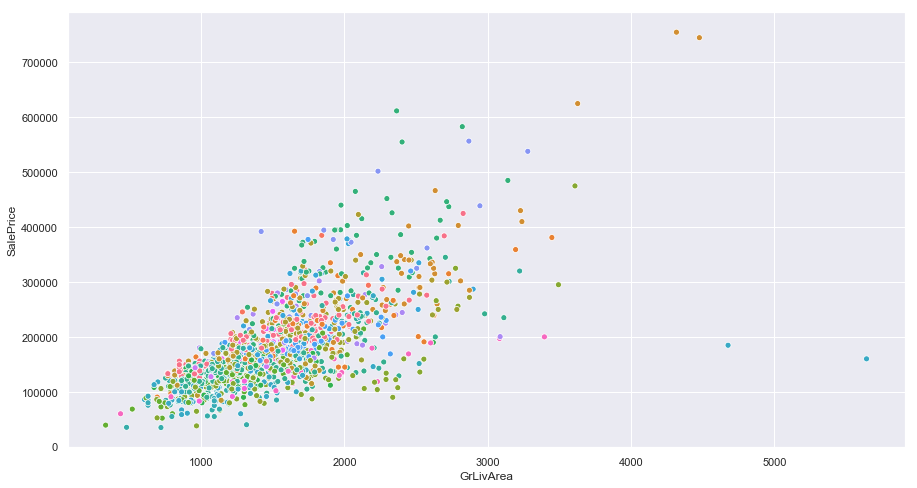

In [54]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = df_train['GrLivArea'], y = df_train['SalePrice'], hue = df_train['Neighborhood'], legend = False)

We notice two points out of the "line" which are very od and we want to remove it.

In [55]:
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

**TotalArea**

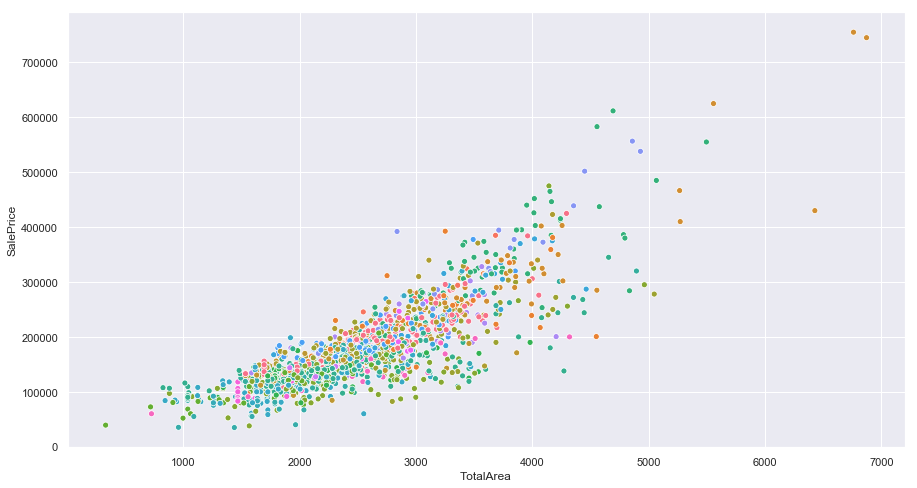

In [56]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = df_train['TotalArea'], y = df_train['SalePrice'], hue = df_train['Neighborhood'], legend = False)

TotalArea seems fine and looks like a linea-ish relation.

**OverallQual**

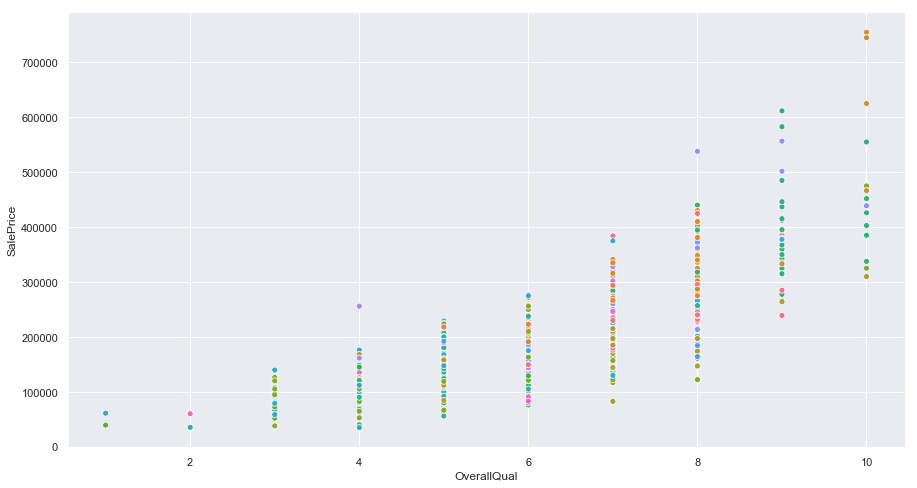

In [57]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = df_train['OverallQual'], y = df_train['SalePrice'], hue = df_train['Neighborhood'], legend = False)

OverallQual seems fine.

How is our train set now?

In [58]:
len_train = df_train.shape[0]
len_train

1458

**Joining both datasets**

In [59]:
df_concat = pd.concat([df_train, df_test], sort = False)

In [60]:
df_concat.shape

(2917, 79)

In [61]:
df_concat = df_concat.drop("Id", axis = 1)

### LOG TRANSFORM TARGET VARIABLE

The target sale price is very skewed so to normalize it we log the target and it become more robust to the model.

Skew: 2.55


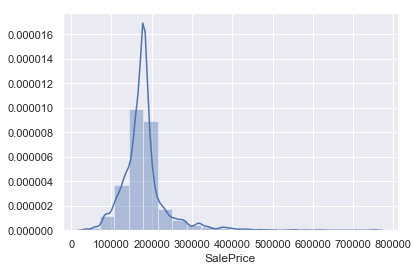

In [62]:
sns.distplot(df_concat['SalePrice'], bins = 20)
print("Skew:", round(df_concat['SalePrice'].skew(),2))

In [63]:
df_concat["SalePrice"] = np.log1p(df_concat["SalePrice"])

Skew: -0.15


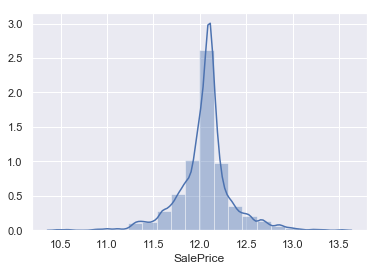

In [64]:
sns.distplot(df_concat['SalePrice'], bins = 20)
print("Skew:", round(df_concat['SalePrice'].skew(),2))

### MISSING VALUES

**Separating continues from categorical features**

In [87]:
continuous = []
categorical = []

for i in df_concat.columns:
    if df_concat[i].dtype == "object":
        categorical.append(i)
    else: continuous.append(i)

print("Continuous:", continuous)
print("-")
print("Categorical:", categorical)

Continuous: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'TotalArea']
-
Categorical: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQua

#### Categorical

In [88]:
isna_sum = df_concat[categorical].isna().sum()
NaN_columns = [i for i in isna_sum.index if df_concat[i].isna().sum() !=0]
df_NaN_values = df_concat[NaN_columns]
missing_categorical = pd.DataFrame(df_NaN_values.isna().sum(), columns = ["Missing values"])
missing_categorical.sort_values(["Missing values"], axis = 0, ascending = False)

,Missing values
PoolQC,2908
MiscFeature,2812
Alley,2719
Fence,2346
FireplaceQu,1420
GarageQual,159
GarageFinish,159
GarageCond,159
GarageType,157
BsmtCond,82


Functional: Home functionality (Assume typical unless deductions are warranted)

- Typ	Typical Functionality
- Min1	Minor Deductions 1
- Min2	Minor Deductions 2
- Mod	Moderate Deductions
- Maj1	Major Deductions 1
- Maj2	Major Deductions 2
- Sev	Severely Damaged
- Sal	Salvage only

In [89]:
df_concat["Functional"].fillna("Typ", inplace = True)

Reading the descriptions of the following features, it is noticeble that an NA means not present so let`s fill the missing with "NA"

In [90]:
for i in ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2', "MasVnrType", "MSSubClass", "FireplaceQu"]:
    
    df_concat[i].fillna("NA", inplace = True)

In [91]:
isna_sum = df_concat[categorical].isna().sum()
NaN_columns = [i for i in isna_sum.index if df_concat[i].isna().sum() !=0]
df_NaN_values = df_concat[NaN_columns]
df_NaN_values.isna().sum()

MSZoning       4
Utilities      2
Exterior1st    1
Exterior2nd    1
Electrical     1
KitchenQual    1
SaleType       1
dtype: int64

Now that we filled most of the missing values let's fill the rest with the most common value of the feature, the mode.

In [92]:
for i in ["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "Electrical", "KitchenQual", "SaleType"]:
    df_concat[i].fillna(df_concat[i].mode()[0], inplace = True)

#### Continuous

In [93]:
isna_sum = df_concat[continuous].isna().sum()
NaN_columns = [i for i in isna_sum.index if df_concat[i].isna().sum() !=0]
df_NaN_values = df_concat[NaN_columns]
missing_continuous = pd.DataFrame(df_NaN_values.isna().sum(), columns = ["Missing values"])
missing_continuous.sort_values(["Missing values"], axis = 0, ascending = False)

,Missing values
LotFrontage,486
GarageYrBlt,159
MasVnrArea,23
BsmtFullBath,2
BsmtHalfBath,2
BsmtFinSF1,1
BsmtFinSF2,1
BsmtUnfSF,1
GarageCars,1
GarageArea,1


The **LotFrontage** is the most critical value to be missing, because it means **"Linear feet of street connected to property"**. Therefore its value is possible very correlated with the price. It makes sense that most of the houses in a Neighborhood have a somewhat similar value for this feature. Hence, to solve this issue we group by neighborhood and fill in missing values by the median of all the neighborhood.

In [24]:
df_concat["LotFrontage"] = df_concat.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

For the same reason of the related features in categorical data, it is noticeble that a missing value means not present so let`s fill the missing with 0.

In [25]:
for i in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 
            'BsmtHalfBath', "MasVnrArea", "TotalArea"):
    
    df_concat[i].fillna(0, inplace = True)

**Is there still any missing value?**

In [26]:
sum(df_concat.isna().sum())

0

### SKEWED CONTINUOUS FEATURES

In [27]:
big_skew = [feature for feature in continuous if abs(df_concat[feature].skew()) > 0.75]

In [28]:
print("High skewed data:", big_skew)
len(big_skew)

High skewed data: ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'TotalArea']


20

**APPLYING BOX COX TRANSFORMATION TO SKEWED DATA**

A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests.

The parameter lambda (0.15) minimizes the standard deviation of a standardized transformed variable. 

In [30]:
for feature in big_skew:
    df_concat[feature] = boxcox1p(df_concat[feature], 0.15)

### GETTING DUMMIES FOR CATEGORICAL VALUES

In [31]:
df_concat = pd.get_dummies(df_concat)
print(df_concat.shape)

(2917, 301)


In [32]:
df_concat.shape

(2917, 301)

### SPLITTING THE DATA

In [82]:
len_train

1458

In [34]:
train_set_final = df_concat.iloc[:len_train,:]
test_set_final = df_concat.iloc[len_train:,:]

In [35]:
print(train_set_final.shape)
print(test_set_final.shape)

(1458, 301)
(1459, 301)


## BUILDING THE PREDICTION MODEL

Splitting the train data frame into train and test subsets

In [36]:
X = train_set_final.drop('SalePrice',axis=1)
y = train_set_final[['SalePrice']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

Data for prediction and submit

In [37]:
X_submission = test_set_final.drop('SalePrice',axis=1)

Models to test the score

In [39]:
modelsFinal = []
modelsFinal.append(('ENet', make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))))
modelsFinal.append(('Lasso', make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))))
modelsFinal.append(('RF',RandomForestRegressor()))
modelsFinal.append(('GB',GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)))
modelsFinal.append(("KRR",KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)))
modelsFinal.append(("Xgb",xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)))

In [40]:
def compute_models(X, y):
    names = []
    scores = []
    frame = pd.DataFrame()
    
    for name, model in modelsFinal:
        model.fit(X, y)
        prediction = model.predict(X_submission)
        frame[name] = prediction
        scores.append(model.score(X_test,y_test))
        names.append(name)
    
    bla = pd.DataFrame(scores, index = names, columns = ["score"])
    print(bla)
    
    return frame

In [41]:
frame = compute_models(X_train, y_train)

          score
ENet   0.914687
Lasso  0.914766
RF     0.863454
GB     0.904175
KRR    0.880568
Xgb    0.911105


In [42]:
frame.head()

,ENet,Lasso,RF,GB,KRR,Xgb
0,11.679198,11.680026,11.762927,11.731262,11.714788,11.732427
1,11.949312,11.948870,11.933802,11.995827,12.023884,11.992205
2,12.126306,12.125854,12.051103,12.166806,12.188283,12.161936
3,12.198864,12.200004,12.177129,12.221538,12.225506,12.176467
4,12.151132,12.149842,12.174028,12.137113,12.064865,12.140879


It is possible to note that the models build over ENet and Lasso and Xgb have a higher score. So lets create a column with the mean value of the 3 predictions. Mixing models is known to increase accuracy.

In [43]:
frame["mean"] = (frame["ENet"] + frame["Lasso"] + frame["Xgb"])/3

In [44]:
frame.head(10)

,ENet,Lasso,RF,GB,KRR,Xgb,mean
0,11.679198,11.680026,11.762927,11.731262,11.714788,11.732427,11.697217
1,11.949312,11.948870,11.933802,11.995827,12.023884,11.992205,11.963462
2,12.126306,12.125854,12.051103,12.166806,12.188283,12.161936,12.138032
3,12.198864,12.200004,12.177129,12.221538,12.225506,12.176467,12.191778
4,12.151132,12.149842,12.174028,12.137113,12.064865,12.140879,12.147284
5,12.047867,12.047637,12.103271,12.042377,12.056743,12.073637,12.056380
6,12.059907,12.063144,12.084218,12.084885,12.072778,12.085721,12.069591
7,11.986248,11.986068,12.097517,12.009845,11.980376,11.998858,11.990391
8,12.193559,12.189330,12.241726,12.080789,12.160974,12.158720,12.180536
9,11.681843,11.681471,11.763226,11.733084,11.706942,11.699027,11.687447


# SUBMITION

In [45]:
Id = sub_df["Id"].values
predictions_id = list(zip(Id,frame["mean"]))

In [46]:
submission = pd.DataFrame(predictions_id , columns = ["Id", "SalePrice"])

Predicted value in log form

In [47]:
submission.head()

,Id,SalePrice
0,1461,11.697217
1,1462,11.963462
2,1463,12.138032
3,1464,12.191778
4,1465,12.147284


Converting to original format

In [48]:
submission["SalePrice"] = np.expm1(submission["SalePrice"])

In [49]:
submission.head()

,Id,SalePrice
0,1461,120235.618770
1,1462,156914.408902
2,1463,186843.500620
3,1464,197160.478320
4,1465,188580.239876


In [50]:
len(submission)

1459

### SAVING FILE

In [51]:
submission.to_csv('submission_20.csv',sep=',', encoding='utf-8', index=False)

In [52]:
submission["SalePrice"].isna().sum()

0

### SCORE: 0.11958 - position 866 (top 19%)
**Accuracy around 91%**

In [ ]:
def nota(score):
    m = (30-18)/(0.112-0.132)
    nota = m*(score - 0.122) + 24
    return nota

In [81]:
round(nota(0.11958),2)

25.45

# TO DO:

- Explain the parameters of the models
- Try filling pool missing features with average for those who have pool